In [ ]:
# kernel restart required after install
!pip install dmba xgboost lightgbm

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import randint
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import seaborn as sns
from io import StringIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import cross_val_score,GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc
from sklearn.exceptions import ConvergenceWarning
from sklearn.preprocessing import LabelEncoder
from dmba import plotDecisionTree, classificationSummary, regressionSummary
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from xgboost.sklearn import XGBClassifier
from lightgbm import LGBMClassifier
%matplotlib inline

### Data Understanding & Cleanup

In [3]:
# Create dataframe for the SBS Complaints dataset
sbs_df = pd.read_csv('https://storage.googleapis.com/suptech-week-2024-hackathon/sample-data/sbs/SBS_Dataset_5.csv')

# Display the first five records of the data frame
print(sbs_df.head(5).T)

                                                                               0  \
Complaint Code                                                    1-136603273347   
ID Number                                                               13875999   
Date of entry of complaint                                                4/1/23   
Entry channel                                                      Omnichannel 2   
Agreed Response channel                                                    Email   
Product Code                                                                 NaN   
Product Name                                                         Credit Card   
Specific Product                                            CMR Visa Credit Card   
Complaint Motive Code                                                        NaN   
Motive for Complaint           Inadequate or insufficient information about o...   
Specific Motive for Complaint                                      Care chan

In [4]:
# Determine dimensions of dataframe
print('Dimensions of dataframe:',sbs_df.shape )

Dimensions of dataframe: (89833, 18)


In [5]:
# Check for duplicate records
sbs_df.duplicated().sum()

np.int64(0)

In [6]:
#Identify datatypes of the variables
print(sbs_df.dtypes)

Complaint Code                    object
ID Number                          int64
Date of entry of complaint        object
Entry channel                     object
Agreed Response channel           object
Product Code                     float64
Product Name                      object
Specific Product                  object
Complaint Motive Code            float64
Motive for Complaint              object
Specific Motive for Complaint     object
Sub-motive for Complaint          object
Claimed Amount                   float64
Claimed Currency                 float64
Resolution Date                   object
Type of Resolution                object
Complaint Response               float64
Response Channel                  object
dtype: object


In [7]:
#List no. of unique & null values for all the variables
column_list = [a for a in sbs_df]
# Column Name , Unique Value , Count of Nulls

for col in sbs_df.select_dtypes(['object','int','float']).columns:
    print(col,':',sbs_df[col].nunique(),':',sbs_df[col].isna().sum())

Complaint Code : 89579 : 0
ID Number : 70544 : 0
Date of entry of complaint : 364 : 0
Entry channel : 10 : 0
Agreed Response channel : 2 : 0
Product Code : 0 : 89833
Product Name : 6 : 0
Specific Product : 27 : 0
Complaint Motive Code : 0 : 89833
Motive for Complaint : 14 : 0
Specific Motive for Complaint : 15 : 0
Sub-motive for Complaint : 42 : 0
Claimed Amount : 0 : 89833
Claimed Currency : 0 : 89833
Resolution Date : 355 : 16
Type of Resolution : 2 : 0
Complaint Response : 0 : 89833
Response Channel : 2 : 0


Product Name
Credit Card        75.78
No Product         15.63
Savings             5.54
Consumer Credit     2.79
CTS Account         0.17
Time Account        0.09
Name: count, dtype: float64


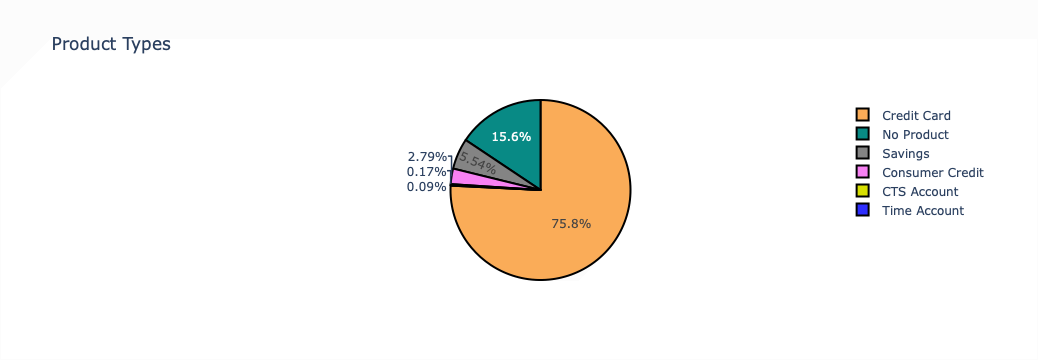

In [9]:
product_percentage = round(sbs_df["Product Name"].value_counts() / len(sbs_df["Product Name"]) * 100,2)

print(product_percentage)

labels = list(product_percentage.index)
values = product_percentage.values.tolist() 
colors = ['#FAAC58', '#088A85', '#848484', '#F781F3', '#D7DF01', '#2E2EFE']
product_pie = go.Pie(labels=labels, values=values, 
                          marker=dict(colors=colors,
                         line=dict(color='#000000', width=2)))
layout = go.Layout(title='Product Types')

fig = go.Figure(data=[product_pie], layout=layout)
iplot(fig)

In [10]:
sbs_df['Specific Product'].value_counts()

Specific Product
CMR Visa Credit Card           42026
Visa Platinum Credit Card      16140
No Product                     14038
CMR Visa Signature              9093
Flex Account                    2904
Super Cash Cash Loan            2179
Simple Account                   752
Dependent Salary Account         651
Expired credit card              627
Traditional Savings              528
Refinanced Credit                322
CMR Credit Card                  188
Traditional CTS                  101
Time Deposit                      75
Traditional Savings Dollars       67
Flex Account Dollars              50
Traditional CTS Holding           34
Simple Account Dollars            19
Traditional CTS Dollars            9
Time Deposit Dollars               7
Fisheries CTS                      5
Simple Savings                     5
Auto Credit                        4
Classic Savings                    3
CTS Trad Holding Dollars           3
Purchase Debt                      2
CTS Collaborators    

In [40]:
sbs_df['Specific Motive for Complaint'].value_counts()

Unknown transaction               26870
Transactional Verification        15332
Care channels                     12869
Return                             8013
Payment Issues                     6350
Challenge                          6131
Does not recognize affiliation     3979
Transactional Settings             2980
Customer loyalty                   2976
Notifications to third parties     1759
Incidents at ATMs                  1221
Rectify in Risk Centers            1036
EECC shipping problems              276
Counterfeit Bill                     21
Delay                                20
Name: Specific Motive for Complaint, dtype: int64

In [41]:
# Drop the columns which are not important for the analysis

sbs_df.drop(['Complaint Code','ID Number','Date of entry of complaint','Agreed Response channel', 
          'Product Code', 'Specific Product', 'Claimed Amount', 'Complaint Motive Code', 'Specific Motive for Complaint','Sub-motive for Complaint', 'Claimed Currency', 'Claimed Currency', 'Complaint Response','Resolution Date'],axis=1,inplace=True)

In [42]:
# Dimension of the modified dataset
sbs_df.shape

(89833, 5)

In [43]:
#List no. of null values
sbs_df.isnull().sum()

Entry channel           0
Product Name            0
Motive for Complaint    0
Type of Resolution      0
Response Channel        0
dtype: int64

In [44]:
# Variable - details
sbs_df['Product Name'].value_counts()

Credit Card        68076
No Product         14038
Savings             4979
Consumer Credit     2505
CTS Account          153
Time Account          82
Name: Product Name, dtype: int64

In [45]:
# Variable - details
sbs_df['Entry channel'].value_counts()

Omnichannel 2          73107
Financial Center        5343
Bank Phone Call         5175
Social Media            4155
Operational Support     1021
Contact Us               508
UAC Physical Card        214
Hello Bank               161
Fraud                    148
Legal                      1
Name: Entry channel, dtype: int64

In [46]:
sbs_df['Motive for Complaint'].value_counts()

Unrecognized operations (consumptions, disposals, withdrawals, charges and credits)            49364
Inadequate or insufficient information about operations, products and services                  9986
Improper collections of interest, commissions, expenses and taxes                               8718
Unprocessed/Wrongly Done Transactions                                                           7155
Inadequate customer service                                                                     3127
Problems related to loyalty programs                                                            3065
Contractual modifications of the credit - Dissatisfaction due to problems to make reversals     2509
Disagreement for notifications addressed to third parties                                       1809
ATM related problems                                                                            1437
Improper Report in Risk Centers                                                            

In [47]:
sbs_df['Type of Resolution'].value_counts()

In favor of the user        44953
 in favor of the company    44880
Name: Type of Resolution, dtype: int64

In [48]:
sbs_df['Response Channel'].value_counts()

Email      85673
Courier     4160
Name: Response Channel, dtype: int64

In [11]:
# Encoding
sbs_df = sbs_df.apply(LabelEncoder().fit_transform)

In [12]:
sbs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89833 entries, 0 to 89832
Data columns (total 18 columns):
 #   Column                         Non-Null Count  Dtype
---  ------                         --------------  -----
 0   Complaint Code                 89833 non-null  int64
 1   ID Number                      89833 non-null  int64
 2   Date of entry of complaint     89833 non-null  int64
 3   Entry channel                  89833 non-null  int64
 4   Agreed Response channel        89833 non-null  int64
 5   Product Code                   89833 non-null  int64
 6   Product Name                   89833 non-null  int64
 7   Specific Product               89833 non-null  int64
 8   Complaint Motive Code          89833 non-null  int64
 9   Motive for Complaint           89833 non-null  int64
 10  Specific Motive for Complaint  89833 non-null  int64
 11  Sub-motive for Complaint       89833 non-null  int64
 12  Claimed Amount                 89833 non-null  int64
 13  Claimed Currency

In [13]:
sbs_df.head(10)

,Complaint Code,ID Number,Date of entry of complaint,Entry channel,Agreed Response channel,Product Code,Product Name,Specific Product,Complaint Motive Code,Motive for Complaint,Specific Motive for Complaint,Sub-motive for Complaint,Claimed Amount,Claimed Currency,Resolution Date,Type of Resolution,Complaint Response,Response Channel
0,76653,8681,292,6,1,0,2,2,0,9,0,19,0,0,342,1,0,1
1,77294,51438,316,6,1,0,2,2,0,2,12,32,0,0,342,1,0,1
2,15,37805,4,0,1,0,2,2,0,11,1,1,0,0,4,0,0,1
3,72,38764,4,1,1,0,2,26,0,7,11,7,0,0,4,0,0,1
4,78,46035,4,8,1,0,2,2,0,7,11,7,0,0,4,0,0,1
5,93,34629,4,2,1,0,2,2,0,7,11,7,0,0,4,0,0,1
6,99,21610,4,0,1,0,2,2,0,7,11,7,0,0,4,0,0,1
7,127,22677,4,6,1,0,2,3,0,7,11,7,0,0,4,0,0,1
8,137,15750,4,2,1,0,2,2,0,7,11,7,0,0,4,0,0,1
9,141,48560,4,8,1,0,2,2,0,7,11,7,0,0,4,0,0,1


In [14]:
sbs_df['Type of Resolution'].value_counts()

Type of Resolution
1    44953
0    44880
Name: count, dtype: int64

In [ ]:
# Here, 1 - In favor of user (positive resolution); 2 - In favor of the company (negative resolution)

In [15]:
# X: independent variables, y: dependent variable (outcome)
X = sbs_df.drop(['Type of Resolution'],axis=1)
y = sbs_df['Type of Resolution']

In [16]:
#Data split (80:20)
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.20,
                                                    random_state = 0)

### Logistic Regression 

In [17]:
lreg = LogisticRegression(random_state=1,class_weight='balanced')
lreg.fit(X_train,y_train)
lpred = lreg.predict(X_test)

In [18]:
print(metrics.accuracy_score(y_test,lpred))

0.6344409194634608


In [19]:
lprob = np.round(lreg.predict_proba(X_test), decimals=4)

In [20]:
print(roc_auc_score(y_test, lreg.predict_proba(X_test)[:,1]))

fpr, tpr, _ = roc_curve(y_test, lprob[:,1])
plt.figure(figsize=[5, 5])
lw = 2

plt.plot(fpr, tpr,color='red',
         lw=lw)
plt.plot([0, 1], [0, 1], color='blue', lw=lw, linestyle='--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()

0.6743092767286167


In [21]:
# Confusion matrices for multiple predictors logistic model. 

# Identify and display confusion matrix for train set. 
print('Train - Partition')
classificationSummary(y_train, lreg.predict(X_train))

# Identify and display confusion matrix for test set. 
print()
print('Test - Partition')
classificationSummary(y_test, lreg.predict(X_test))
print(classification_report(y_test, lreg.predict(X_test)))

Train - Partition
Confusion Matrix (Accuracy 0.6334)

       Prediction
Actual     0     1
     0 21006 14830
     1 11513 24517

Test - Partition
Confusion Matrix (Accuracy 0.6344)

       Prediction
Actual    0    1
     0 5324 3720
     1 2848 6075
              precision    recall  f1-score   support

           0       0.65      0.59      0.62      9044
           1       0.62      0.68      0.65      8923

    accuracy                           0.63     17967
   macro avg       0.64      0.63      0.63     17967
weighted avg       0.64      0.63      0.63     17967



<AxesSubplot: >

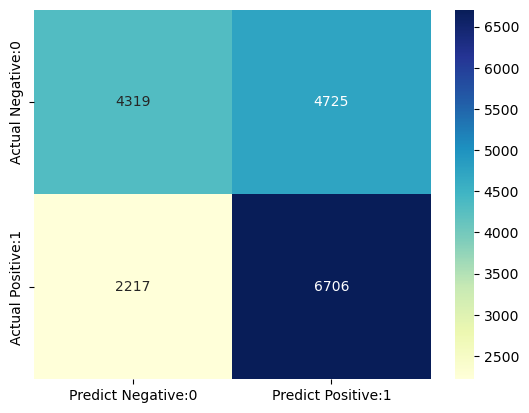

In [60]:
cm = confusion_matrix(y_test, lreg.predict(X_test))
cm_matrix = pd.DataFrame(data=cm, columns= ['Predict Negative:0','Predict Positive:1'], 
                                 index=[ 'Actual Negative:0','Actual Positive:1'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

In [26]:
#Feature importance 
importances = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': lreg.coef_[0]
})
importances = importances.sort_values(by='Importance', ascending=False)

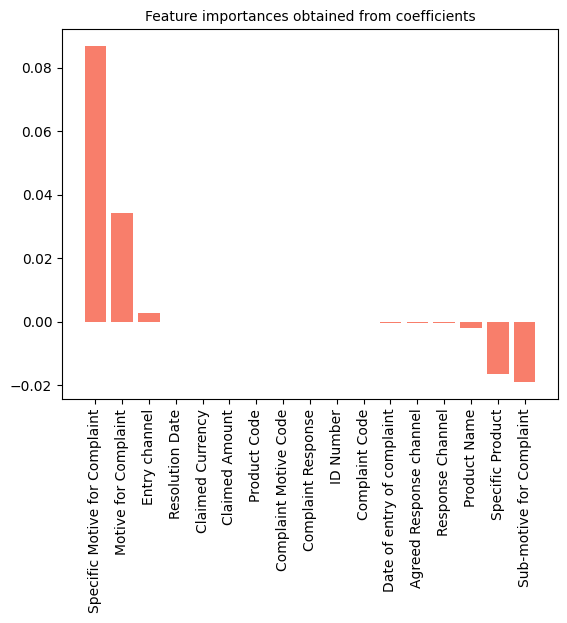

In [27]:
plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#F87E6B')
plt.title('Feature importances obtained from coefficients', size=10)
plt.xticks(rotation='vertical')
plt.show()

In [ ]:
# Accuracy is not high for logistic regression (~61%). However, the important predictors for the classification model are 
# (1) 'Response Channel', (2) 'Product Name', (3) 'Motive for Complaint', and (4) 'Entry channel'

### XGBoost with Grid Search

In [28]:
xgb = XGBClassifier(num_class = 2,
                    objective="multi:softprob",
                    eval_metric="mlogloss",
                    seed=42) 

In [29]:
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_class=2, num_parallel_tree=None, ...)

In [30]:
xgbpred=xgb.predict(X_test)

In [ ]:
print(metrics.accuracy_score(y_test,xgbpred))
print('Confusion matrix')
xgb_cm=metrics.confusion_matrix(y_test, xgbpred)


lbl1=["Predicted 1", "Predicted 2"]
lbl2=["Actual 1", "Actual 2"]

sns.heatmap(xgb_cm, annot=True,cmap='YlGnBu', fmt="d", xticklabels=lbl1, yticklabels=lbl2)

plt.show()

print('Classification report')
print(metrics.classification_report(y_test,xgbpred))

In [32]:
predict_probabilities = xgb.predict_proba(X_test)
print(roc_auc_score(y_test, predict_probabilities[:,1]))

0.8485226050405298


In [33]:
#Hyper parameter tuning

xgb_gs = XGBClassifier(num_class = 2,
                           objective="multi:softprob",
                           seed=42)                         
                        
param_grid = {"max_depth": [10,15,20],
              "n_estimators": range(5,20,5), 
              "gamma": [0.03,0.05], 
              "learning_rate": [0.01,0.05]}


grid_search = GridSearchCV(xgb_gs, 
                           param_grid=param_grid,
                           cv = 5,
                           n_jobs=-1,
                           scoring='neg_log_loss',
                           verbose=2)
grid_search.fit(X_train,y_train)
grid_search.best_params_

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END gamma=0.03, learning_rate=0.01, max_depth=10, n_estimators=5; total time=   0.9s
[CV] END gamma=0.03, learning_rate=0.01, max_depth=10, n_estimators=5; total time=   0.7s
[CV] END gamma=0.03, learning_rate=0.01, max_depth=10, n_estimators=5; total time=   0.7s
[CV] END gamma=0.03, learning_rate=0.01, max_depth=10, n_estimators=10; total time=   1.1s
[CV] END gamma=0.03, learning_rate=0.01, max_depth=10, n_estimators=10; total time=   1.1s
[CV] END gamma=0.03, learning_rate=0.01, max_depth=10, n_estimators=15; total time=   1.5s
[CV] END gamma=0.03, learning_rate=0.01, max_depth=10, n_estimators=15; total time=   1.5s
[CV] END gamma=0.03, learning_rate=0.01, max_depth=10, n_estimators=15; total time=   1.5s
[CV] END gamma=0.03, learning_rate=0.01, max_depth=15, n_estimators=5; total time=   1.9s
[CV] END gamma=0.03, learning_rate=0.01, max_depth=15, n_estimators=5; total time=   2.0s
[CV] END gamma=0.03, learning_rat

{'gamma': 0.05, 'learning_rate': 0.05, 'max_depth': 20, 'n_estimators': 15}

/Users/nitya/opt/anaconda3/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/nitya/opt/anaconda3/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/nitya/opt/anaconda3/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pa

/Users/nitya/opt/anaconda3/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/nitya/opt/anaconda3/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/nitya/opt/anaconda3/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pa

/Users/nitya/opt/anaconda3/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/nitya/opt/anaconda3/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/nitya/opt/anaconda3/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pa

/Users/nitya/opt/anaconda3/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/nitya/opt/anaconda3/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/nitya/opt/anaconda3/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pa

/Users/nitya/opt/anaconda3/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/nitya/opt/anaconda3/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/nitya/opt/anaconda3/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pa

/Users/nitya/opt/anaconda3/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/nitya/opt/anaconda3/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/nitya/opt/anaconda3/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pa

/Users/nitya/opt/anaconda3/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/nitya/opt/anaconda3/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/nitya/opt/anaconda3/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pa

/Users/nitya/opt/anaconda3/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/nitya/opt/anaconda3/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/nitya/opt/anaconda3/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pa

/Users/nitya/opt/anaconda3/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/nitya/opt/anaconda3/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/nitya/opt/anaconda3/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pa

/Users/nitya/opt/anaconda3/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/nitya/opt/anaconda3/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/nitya/opt/anaconda3/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pa

/Users/nitya/opt/anaconda3/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/nitya/opt/anaconda3/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/nitya/opt/anaconda3/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pa

/Users/nitya/opt/anaconda3/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/nitya/opt/anaconda3/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/nitya/opt/anaconda3/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pa

/Users/nitya/opt/anaconda3/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/nitya/opt/anaconda3/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/nitya/opt/anaconda3/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pa

/Users/nitya/opt/anaconda3/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/nitya/opt/anaconda3/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/nitya/opt/anaconda3/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pa

[20:39:16] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


{'gamma': 0.05, 'learning_rate': 0.05, 'max_depth': 15, 'n_estimators': 15}

In [69]:
xgb_ypred=grid_search.predict(X_test)    

In [ ]:
print(metrics.accuracy_score(y_test,xgb_ypred))

print('Confusion matrix')
xgb_cfm=metrics.confusion_matrix(y_test, xgb_ypred)


lbl1=["Predicted 1", "Predicted 2"]
lbl2=["Actual 1", "Actual 2"]

sns.heatmap(xgb_cfm, annot=True, cmap="YlGnBu", fmt="d", xticklabels=lbl1, yticklabels=lbl2)

plt.show()

print('Classification report')
print(metrics.classification_report(y_test,xgb_ypred))


[CV] END gamma=0.05, learning_rate=0.05, max_depth=20, n_estimators=15; total time=  10.4s
[CV] END gamma=0.03, learning_rate=0.01, max_depth=10, n_estimators=5; total time=   1.0s
[CV] END gamma=0.03, learning_rate=0.01, max_depth=10, n_estimators=5; total time=   0.8s
[CV] END gamma=0.03, learning_rate=0.01, max_depth=10, n_estimators=10; total time=   1.2s
[CV] END gamma=0.03, learning_rate=0.01, max_depth=10, n_estimators=10; total time=   1.0s
[CV] END gamma=0.03, learning_rate=0.01, max_depth=10, n_estimators=10; total time=   1.1s
[CV] END gamma=0.03, learning_rate=0.01, max_depth=10, n_estimators=15; total time=   1.5s
[CV] END gamma=0.03, learning_rate=0.01, max_depth=10, n_estimators=15; total time=   1.5s
[CV] END gamma=0.03, learning_rate=0.01, max_depth=15, n_estimators=5; total time=   2.0s
[CV] END gamma=0.03, learning_rate=0.01, max_depth=15, n_estimators=5; total time=   1.9s
[CV] END gamma=0.03, learning_rate=0.01, max_depth=15, n_estimators=5; total time=   1.9s
[CV

In [ ]:
predict_probabilities = grid_search.predict_proba(X_test)
print(roc_auc_score(y_test, predict_probabilities[:,1]))

### Light GBM

In [74]:
lgbm = LGBMClassifier(random_state=1,
                n_estimators=500,                
                learning_rate=0.05,      
                subsample=0.7)
lgbm.fit(X_train, y_train)

LGBMClassifier(learning_rate=0.05, n_estimators=500, random_state=1,
               subsample=0.7)

In [ ]:
lgbmpred=lgbm.predict(X_test)

[20:37:32] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END gamma=0.03, learning_rate=0.01, max_depth=10, n_estimators=5; total time=   2.1s
[20:37:34] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END gamma=0.03, learning_rate=0.01, max_depth=10, n_estimators=15; total time=   5.9s
[20:37:40] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END gamma=0.03, learning_rate=0.01, max_depth=15, n_est

[20:37:32] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END gamma=0.03, learning_rate=0.01, max_depth=10, n_estimators=10; total time=   4.1s
[20:37:36] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END gamma=0.03, learning_rate=0.01, max_depth=10, n_estimators=15; total time=   6.0s
[20:37:42] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END gamma=0.03, learning_rate=0.01, max_depth=15, n_es

[20:37:32] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END gamma=0.03, learning_rate=0.01, max_depth=10, n_estimators=5; total time=   2.1s
[20:37:34] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END gamma=0.03, learning_rate=0.01, max_depth=10, n_estimators=15; total time=   6.0s
[20:37:40] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END gamma=0.03, learning_rate=0.01, max_depth=15, n_est

[20:37:32] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END gamma=0.03, learning_rate=0.01, max_depth=10, n_estimators=5; total time=   2.1s
[20:37:34] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END gamma=0.03, learning_rate=0.01, max_depth=10, n_estimators=10; total time=   4.0s
[20:37:38] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END gamma=0.03, learning_rate=0.01, max_depth=15, n_est

In [ ]:
print(metrics.accuracy_score(y_test,lgbmpred))
print('Confusion matrix')
lgbm_cm=metrics.confusion_matrix(y_test, lgbmpred)


lbl1=["Predicted 1", "Predicted 2"]
lbl2=["Actual 1", "Actual 2"]

sns.heatmap(lgbm_cm, annot=True,cmap='YlGnBu', fmt="d", xticklabels=lbl1, yticklabels=lbl2)

plt.show()

print('Classification report')
print(metrics.classification_report(y_test,lgbmpred))

In [ ]:
#calculate ROC AUC of model
predict_probabilities = lgbm.predict_proba(X_test)
print(roc_auc_score(y_test, predict_probabilities[:,1]))

In [ ]:
#Hyper parameter tuning

param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'reg_lambda': [1, 3, 5, 10] 
}

# Apply GridSearchCV() function 

gridSearch_LGBM = GridSearchCV(LGBMClassifier(n_estimators=500,reg_alpha = 1,max_depth=6,learning_rate=0.05,      
                subsample=0.7,booster='gbtree',random_state=1), 
                param_grid, cv=5, n_jobs=-1)
gridSearch_LGBM.fit(X_train,y_train)

# Display best improved paramenters of classification tree. 
print()
print(f'Improved score:{gridSearch_LGBM.best_score_:.4f}')
print('Improved parameters: ', gridSearch_LGBM.best_params_)


In [82]:
lgbm_ypred=grid_search.predict(X_test)    

In [ ]:
print(metrics.accuracy_score(y_test,lgbm_ypred))

print('Confusion matrix')
lgbm_cfm=metrics.confusion_matrix(y_test, lgbm_ypred)


lbl1=["Predicted 1", "Predicted 2"]
lbl2=["Actual 1", "Actual 2"]

sns.heatmap(lgbm_cfm, annot=True, cmap="YlGnBu", fmt="d", xticklabels=lbl1, yticklabels=lbl2)

plt.show()

print('Classification report')
print(metrics.classification_report(y_test,lgbm_ypred))

In [ ]:
predict_probabilities = gridSearch_LGBM.predict_proba(X_test)
print(roc_auc_score(y_test, predict_probabilities[:,1]))

In [ ]:
# XGBoost & LightGBM - Slightly better accuracy for the model at ~65%. Grid Search did not lead to major accuracy improvement.  

### Prediction

In [ ]:
# prediction with new test set

new_test = sbs_df.sample(6, random_state=111).copy()
print(new_test)

In [90]:
new_test.drop(['Type of Resolution'],axis=1,inplace=True)

In [91]:
xgbpred_new=grid_search.predict(new_test)

In [92]:
xgbpred_new

array([0, 1, 0, 1, 1, 1])

In [ ]:
# Accuracy: actual resolution type - 1,0,0,1,0,1 v/s predicted resolution type - 0,1,0,1,1,1